# **Soynlp 의 Noun Extractor ver 2()** 
> ! pip install soynlp

1. **Unsupervised tokenizers** in **[soynlp project](https://lovit.github.io/nlp/2018/04/09/three_tokenizers_soynlp/)**
1. 비지도 학습방법을 활용한 **명사 Token 추출 방법을** 익힙니다.

## **0 MeCab() 을 활용한 미등록 명사 추출**
- ! pip show soynlp
- ! cat ./data/petition.csv | head -n 2  # 내용 살펴보기
- 개별 모듈의 사전의 내용과 성격에 따라 결과가 다른만큼 보정이 어려운 단점이 있습니다

In [1]:
# -*- encoding:utf8 -*-
import konlpy
from konlpy.tag import Mecab
print('konlpy version = %s' % konlpy.__version__)

sent = '트와이스와 아이오아이가 활동시절 박근혜 최순실의 국정농단 사태는 대통령탄핵으로 이어졌습니다'
"MeCab() 명사추출 :", Mecab().nouns(sent)[:6]

konlpy version = 0.5.1


('MeCab() 명사추출 :', ['트', '이스', '아이오', '아이', '활동', '시절'])

## **1 Noun Extractor ver 2() 학습모델 만들기**
1. **2016년 까지 수집한 뉴스 텍스트를** 바탕으로 모델을 생성합니다.
1. **어절간의 결합 엔트로피를** 계산합니다. **단어간 경계에 엔트로피가 크게 증가함을** 근거로 단어를 구분 합니다
1. **nouns** 는 **{ str : namedtuple }** 형식으로 추출 됩니다.

In [3]:
%%time
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2

corpus_path = './data/news_2016-10-20.txt'
corpus = DoublespaceLineCorpus(corpus_path, iter_sent=True) # Soynlp Corpus 변환
noun_extractor = LRNounExtractor_v2(verbose=True)           # Soynlp 모델의 정의
nouns = noun_extractor.train_extract(corpus)                # 모델의 훈련

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 403896 from 223357 sents. mem=0.157 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=4434442, mem=0.885 Gb
[Noun Extractor] batch prediction was completed for 146445 words
[Noun Extractor] checked compounds. discovered 69793 compounds
[Noun Extractor] postprocessing detaching_features : 118538 -> 101025
[Noun Extractor] postprocessing ignore_features : 101025 -> 100918
[Noun Extractor] postprocessing ignore_NJ : 100918 -> 100496
[Noun Extractor] 100496 nouns (69793 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.078 Gb                    
[Noun Extractor] 80.22 % eojeols are covered
CPU times: user 37.8 s, sys: 525 ms, total: 38.3 s
Wall time: 38.1 s


In [4]:
list(noun_extractor._compounds_components.items())[:5]

[('잠수함발사탄도미사일', ('잠수함', '발사', '탄도미사일')),
 ('미사일대응능력위원회', ('미사일', '대응', '능력', '위원회')),
 ('글로벌녹색성장연구소', ('글로벌', '녹색성장', '연구소')),
 ('시카고옵션거래소', ('시카고', '옵션', '거래소')),
 ('대한민국특수임무유공', ('대한민국', '특수', '임무', '유공'))]

In [5]:
nouns['뉴스'] # NounScore(frequency=4319, score=1.0)

NounScore(frequency=4317, score=1.0)

In [6]:
nouns['부산과학기술기획평가']

NounScore(frequency=1.0, score=0)

## **2 학습모델로 새로운 명사 추출하기**
1. **2016년 까지 수집한 뉴스 텍스트를** 바탕으로 모델을 생성합니다.
1. **어절간의 결합 엔트로피를** 계산합니다. **단어간 경계에 엔트로피가 크게 증가함을** 근거로 단어를 구분 합니다
1. **nouns** 는 **{ str : namedtuple }** 형식으로 추출 됩니다.

In [7]:
# nouns['두바이월드센터시카고옵션거래소']
noun_extractor.decompose_compound('두바이월드센터시카고옵션거래소를')

('두바이', '월드', '센터', '시카고', '옵션', '거래소')

In [14]:
# nouns['두바이월드센터시카고옵션거래소']
noun_extractor.decompose_compound('햄버거짬뽕')

('햄버거', '짬뽕')

In [7]:
noun_extractor.decompose_compound('한국아이티비지니스진흥협회의')

('한국', '아이티', '비지니스', '진흥', '협회')

In [8]:
# 단 영어가 포함된 경우에는 엔트로피 측정이 잘 안됨에 주의
noun_extractor.decompose_compound('한국IT비지니스진흥협회에서')

('한국IT비지니스진흥협회에서',)

In [9]:
# 학습내용과 무관한 단어들은 구분능력이 떨어짐 (당연하지..)
noun_extractor.decompose_compound('복만두를강냉이와')

('복만두를강냉이와',)

In [10]:
noun_extractor.lrgraph.get_r('아이오아이')

[('', 123),
 ('의', 47),
 ('는', 40),
 ('와', 18),
 ('가', 18),
 ('에', 7),
 ('에게', 6),
 ('까지', 2),
 ('랑', 2),
 ('부터', 1)]

In [11]:
# topk=10 으로 설정되어 있습니다. topk < 0 으로 설정하면 모든 R set 이 출력됩니다.
noun_extractor.lrgraph.get_r('아이오아이', topk=-1)

[('', 123),
 ('의', 47),
 ('는', 40),
 ('와', 18),
 ('가', 18),
 ('에', 7),
 ('에게', 6),
 ('까지', 2),
 ('랑', 2),
 ('부터', 1),
 ('도', 1),
 ('와의', 1),
 ('와는', 1),
 ('로', 1),
 ('를', 1),
 ('에서', 1)]

In [12]:
# L-R 구조의 L parts 도 확인할 수 있습니다. 이 역시 topk=10 으로 기본값이 설정되어 있습니다.
noun_extractor.lrgraph.get_l('었다고')

[('있', 125),
 ('없', 76),
 ('만들', 37),
 ('늘', 32),
 ('맺', 29),
 ('열', 28),
 ('들', 19),
 ('입', 16),
 ('되', 14),
 ('줄', 14)]

## **3 LRGraph 를 활용한 데이터의 L-R 구조 확인**
**soynlp.utils** 의 **LRGraph** 를 이용하면 **데이터의 L-R 구조를** 살펴볼 수 있습니다.
1. 한국어의 어절은 **L(의미단어) + [R](문법단어)** 구조입니다. 
1. 문법은 사회적 약속이고 쉽게 바뀌지 않아 **closed class** 를 사용 합니다.
1. 데이터에서 추출하는 **새로운 개념의 단어** 를 **L part** 라고 합니다.

https://github.com/lovit/soynlp/blob/6632449319eac3e51b3f6ffbc1cf65dd7096678e/tutorials/wordextractor_lecture.ipynb

In [16]:
%%time
from soynlp.word import WordExtractor

word_extractor = WordExtractor(
    min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)

print('num sentences = {:,}'.format(len(corpus)))
word_extractor.train(corpus)
words = word_extractor.extract()
len(words)

num sentences = 223,357
training was done. used memory 1.627 Gbse memory 1.675 Gb
all cohesion probabilities was computed. # words = 16942
all branching entropies was computed # words = 355061
all accessor variety was computed # words = 355061
CPU times: user 52.7 s, sys: 823 ms, total: 53.5 s
Wall time: 53.5 s


14325

In [17]:
import math
def word_score(score):
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

print('단어   (빈도수, cohesion, branching entropy)\n')
for word, score in sorted(words.items(), 
                          key = lambda x:word_score(x[1]), 
                          reverse = True)[:30]:
    print('{:}\t({:5,}, {:.3f}, {:.3f})'.format(
            word, 
            score.leftside_frequency, 
            score.cohesion_forward,
            score.right_branching_entropy))

단어   (빈도수, cohesion, branching entropy)

으로	(1,634, 0.953, 5.334)
까지	(  654, 0.691, 5.349)
함께	(7,946, 0.912, 5.053)
통해	(8,471, 0.578, 5.278)
에서	(7,494, 0.604, 5.187)
된다	(2,681, 0.982, 4.675)
먼저	(1,112, 0.903, 4.665)
면서	(1,944, 0.458, 5.337)
밝혔다	(8,360, 0.836, 4.651)
했다	(7,070, 0.689, 4.795)
됐다	(2,219, 0.750, 4.658)
또한	(2,180, 0.440, 5.086)
같은	(4,429, 0.568, 4.832)
됩니다	(  247, 0.967, 4.272)
새로운	(2,334, 0.578, 4.784)
말했다	(8,345, 0.706, 4.540)
관계자는	(2,942, 0.501, 4.860)
였다	(  211, 0.632, 4.556)
때문에	(4,742, 0.696, 4.436)
과정에서	(  990, 0.497, 4.738)
겁니다	(  518, 0.915, 4.106)
위해	(8,888, 0.367, 5.016)
예정이다	(3,586, 0.607, 4.476)
따라	(3,669, 0.366, 4.977)
따르면	(3,470, 0.589, 4.440)
합니다	(  739, 0.421, 4.766)
왔다	(  674, 0.604, 4.396)
냈다	(  340, 0.659, 4.298)
설명했다	(2,055, 0.612, 4.370)
너무	(1,247, 0.711, 4.209)


In [20]:
%%time
# Cohesion score, Branching Entropy, Accessor Variety 에 대하여 각각의 점수만 이용하고 싶은 경우에는 다음의 함수를 이용합니다
cohesion_scores = word_extractor.all_cohesion_scores()
cohesion_scores['아이오아이'] # (cohesion_forward, cohesion_backward)

all cohesion probabilities was computed. # words = 16942
CPU times: user 116 ms, sys: 60 µs, total: 116 ms
Wall time: 114 ms


(0.30063636035733476, 0)

In [24]:
%%time
# Cohesion score, Branching Entropy, Accessor Variety 에 대하여 각각의 점수만 이용하고 싶은 경우에는 다음의 함수를 이용합니다
cohesion_scores = word_extractor.all_cohesion_scores()
cohesion_scores['아이오아이'] # (cohesion_forward, cohesion_backward)

all cohesion probabilities was computed. # words = 16942
CPU times: user 106 ms, sys: 3.89 ms, total: 110 ms
Wall time: 109 ms


(0.30063636035733476, 0)

In [16]:
%%time
branching_entropy = word_extractor.all_branching_entropy()
branching_entropy['아이오아이'] # (left_branching_entropy, right_branching_entropy)

all branching entropies was computed # words = 355061
CPU times: user 5.32 s, sys: 23 µs, total: 5.32 s
Wall time: 5.32 s


(3.0548011243339506, 2.766022241109869)

In [17]:
%%time
accessor_variety = word_extractor.all_accessor_variety()
accessor_variety['아이오아이'] # (left_accessor_variety, right_accessor_variety)

all accessor variety was computed # words = 355061
CPU times: user 4.32 s, sys: 12 ms, total: 4.33 s
Wall time: 4.33 s


(32, 22)

## **4 명사추출 구조화 방식에 따른 함수의 적용**
https://gist.github.com/lovit/b873e1fbc196e0e8f383414f54b1122e
1. **NonuLMatchTokenizer** 는 어절의 **왼쪽부분에만 명사가 등장한다는** 가정을 한 모델
1. **NounMatchTokenizer** 는 어절의 **왼쪽이 아닌 부분에서 명사가 시작할 수 있다고** 가정한 모델입니다.

In [25]:
%%time
from soynlp.tokenizer import NounLMatchTokenizer, NounMatchTokenizer

# noun_scores[noun] = (score, frequency) : 학습을 위한 데이터로 변환 합니다.
noun_scores      = noun_extractor.train_extract(corpus)
lmatch_tokenizer = NounLMatchTokenizer(nouns = noun_scores)

[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 403896 from 223357 sents. mem=1.632 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=4434442, mem=1.971 Gb
[Noun Extractor] batch prediction was completed for 146445 words
[Noun Extractor] checked compounds. discovered 69793 compounds
[Noun Extractor] postprocessing detaching_features : 118538 -> 101025
[Noun Extractor] postprocessing ignore_features : 101025 -> 100918
[Noun Extractor] postprocessing ignore_NJ : 100918 -> 100496
[Noun Extractor] 100496 nouns (69793 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.927 Gb                    
[Noun Extractor] 80.22 % eojeols are covered
CPU times: user 41.4 s, sys: 325 ms, total: 41.7 s
Wall time: 41.6 s


In [26]:
lmatch_tokenizer.tokenize('오늘의 연합뉴스날씨입니다.')

['오늘', '연합뉴스날씨']

In [28]:
lmatch_tokenizer.tokenize('마파두부야채볶음')

[]

In [20]:
lmatch_tokenizer.tokenize('오늘의 연합뉴스날씨입니다.', compose_compound=False)

['오늘', '연합뉴스', '날씨']

In [21]:
lmatch_tokenizer.tokenize('오늘의 연합뉴스 날씨입니다.')

['오늘', '연합뉴스', '날씨']

In [22]:
lmatch_tokenizer.tokenize('오늘의 ㅋ연합뉴스날씨입니다.')

# NounMatchTokenizer() 는 위 함수대로 작동하지 않습니다,
# match_tokenizer  = NounMatchTokenizer(noun_scores = noun_scores)
# match_tokenizer.tokenize('오늘의 연합뉴스날씨입니다.')
# match_tokenizer.tokenize('오늘의 ㅋ연합뉴스 날씨입니다.')
# match_tokenizer.tokenize('오늘의 ㅋ연합뉴스날씨입니다.', compose_compound=False)

['오늘']

<br></br>
# **명사추출 및 WordCloud 실습**
https://lovit.github.io/nlp/2018/04/09/three_tokenizers_soynlp/

## **1 데이터 불러오기**
1. **[국민 청원 데이터](https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition.csv)** 를 활용한 분석
1. 특정 주제의 청원들로 **Filtering** 합니다

In [24]:
import re
import pandas as pd
df = pd.read_csv('./data/petition.csv', parse_dates=['start', 'end'])
p  = r'.*(대출|집값|부동산|LTV).*'
estate = df[ df['title'].str.match(p) | df['content'].str.match(
                p, flags=re.MULTILINE) ].reset_index(drop=True)
print(estate.shape)

# 특정 인덱스 문서를 Sample 로 추출 합니다.
sample_index   = 15  # 샘플문서 인덱스
sample_title   = estate['title'][sample_index]
sample_content = estate['content'][sample_index]
sample_title,  sample_content[:100]

(27452, 8)


('서울, 강남에만 집이 있는게 아닙니다. 부산도 지금 집값이 엉망인데 왜 외면하십니까?',
 '부동산 투기를 잡고 집값을 안정시키겠다는 대통령님과 정부의 의지에 절대적인 찬성을 보냅니다.\\n지난 정부의 실책으로 투기꾼들은 큰 돈을 벌었을지 모르지만 그렇지 않은 대다수의 국민')

## **2 Soynlp 를 활용한 Word Extractor**
1. Word Extractor 에서 학습 알고리즘은 Cohesion score, Branching Entropy, Accessor Variety 있습니다.
1. 이 포스트에서는 soynlp.word.WordExtractor 의 사용법에 대하여 이야기 합니다.

In [25]:
# 토큰화
from soynlp.tokenizer import RegexTokenizer, LTokenizer, MaxScoreTokenizer
tokenizer       = RegexTokenizer()
tokened_title   = tokenizer.tokenize(sample_title)
tokened_content = tokenizer.tokenize(sample_content)

print(len(tokened_title), len(tokened_content))
tokened_title, tokened_content[:10]

14 403


(['서울',
  ',',
  '강남에만',
  '집이',
  '있는게',
  '아닙니다',
  '.',
  '부산도',
  '지금',
  '집값이',
  '엉망인데',
  '왜',
  '외면하십니까',
  '?'],
 ['부동산', '투기를', '잡고', '집값을', '안정시키겠다는', '대통령님과', '정부의', '의지에', '절대적인', '찬성을'])

In [26]:
%%time
# Preprocessing (개행문자 제거)
def preprocessing(text):
    text = re.sub('\\\\n', ' ', text)
    return text

sentences = estate['content'].apply(preprocessing)
tokens    = sentences.apply(tokenizer.tokenize)
tokens[:3], tokens[sample_index][:10]

CPU times: user 31.1 s, sys: 24 ms, total: 31.1 s
Wall time: 31.1 s


(0    [**, 존경하옵는, 문재인대통령님께, 저는, 중국원양자원이라는, KOSPI, 상장...
 1    [안녕하세요, 대통령님, 금연, 관련, 정책들이, 강화되고, 있지만, 여전히, 흡연...
 2    [8.2, 대책후, 매수세가, 싹, 사라졌습니다, .., 집을, 팔고, 이사를, 해...
 Name: content, dtype: object,
 ['부동산', '투기를', '잡고', '집값을', '안정시키겠다는', '대통령님과', '정부의', '의지에', '절대적인', '찬성을'])

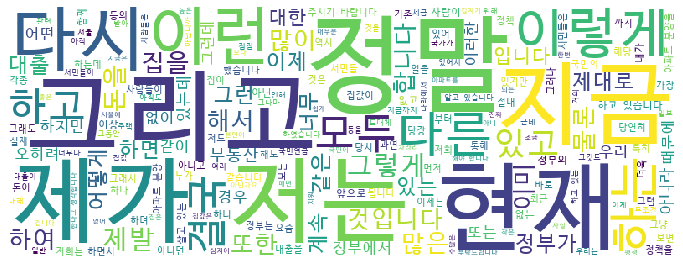

CPU times: user 35.6 s, sys: 1.1 s, total: 36.7 s
Wall time: 36.8 s


In [27]:
%%time
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=300):
    wordcloud = WordCloud( font_path = fontpath,
                           background_color = backgroundcolor, 
                           width = width, height = height).generate(data)
    plt.figure(figsize = (12 , 8))
    plt.imshow(wordcloud); plt.axis("off"); plt.show()

%matplotlib inline
import matplotlib.font_manager as fm
fontpath = "/home/markbaum/.local/share/fonts/D2Coding.ttf"
font = fm.FontProperties(fname=fontpath, size=9)
displayWordCloud(' '.join(sentences))

## **3 Soynlp 를 활용하여 명사만 추출하기**
1. Word Extractor 에서 학습 알고리즘은 Cohesion score, Branching Entropy, Accessor Variety 있습니다.
1. 이 포스트에서는 soynlp.word.WordExtractor 의 사용법에 대하여 이야기 합니다.

[Noun Extractor] used default noun predictor; Sejong corpus predictor
[Noun Extractor] used noun_predictor_sejong
[Noun Extractor] All 2398 r features was loaded
[Noun Extractor] scanning was done (L,R) has (202324, 105117) tokens
[Noun Extractor] building L-R graph was done
[Noun Extractor] 34614 nouns are extracted
추출한 명사갯수 34,614


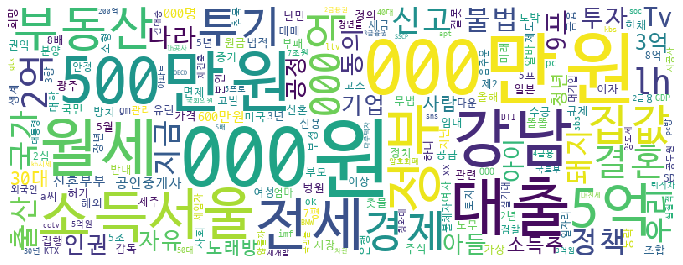

CPU times: user 1min 12s, sys: 68 ms, total: 1min 12s
Wall time: 1min 12s


In [28]:
%%time
# 추출된 명사를 찍어봅니다.
from soynlp.noun import LRNounExtractor
noun_extractor = LRNounExtractor(verbose=True)
noun_extractor.train(sentences)
nouns = noun_extractor.extract()

print("추출한 명사갯수 {:,}".format(len(nouns)))
displayWordCloud(' '.join(nouns))